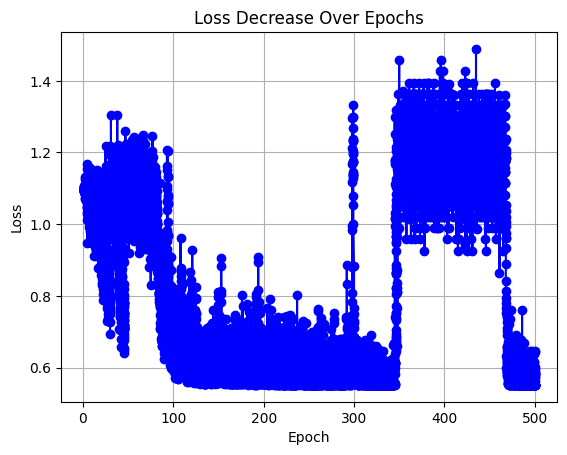

In [5]:
import matplotlib.pyplot as plt

# 从文件中读取损失数据
with open('log.txt', 'r') as file:
    lines = file.readlines()

# 提取 Epoch 和 Loss 数据
epochs = []
losses = []

for line in lines:
    if 'Epoch' in line and 'Loss' in line:
        epoch, loss = line.split(', ')[0], line.split(', ')[1]
        epochs.append(int(epoch.split(': ')[1]))
        losses.append(float(loss.split(': ')[1]))

# 绘制损失下降曲线
plt.plot(epochs, losses, marker='o', linestyle='-', color='b')
plt.title('Loss Decrease Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


In [6]:
import pickle

with open('test_data.pkl', 'rb') as file:
    test_data = pickle.load(file)

with open('all_data.pkl', 'rb') as file:
    all_data = pickle.load(file)


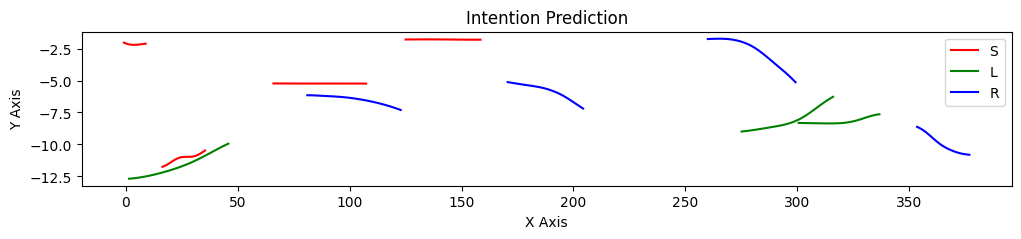

In [7]:
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F
import math
from torch.autograd import Variable

torch.cuda.set_device(0)

device = 'cuda'
batch_size = 32

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=64, num_layers=2, batch_first=True)
        self.fc = nn.Linear(64, 3)
        self.relu = nn.ReLU()

    def forward(self, x):
        # x shape: (batch_size, sequence_length, input_size)
        x = x.view(-1, 125)
        batch_size = x.size(0)
        sequence_length = x.size(1)
        x = x.view(batch_size, sequence_length, 1)
        
        # Apply LSTM
        h0 = torch.zeros(2, batch_size, 64).to(device)  # Initial hidden state
        c0 = torch.zeros(2, batch_size, 64).to(device)  # Initial cell state
        lstm_out, _ = self.lstm(x, (h0, c0))
        
        # Reshape and pass through linear layer
        lstm_out = lstm_out[:, -1, :]  # Take the last time step output
        x = self.relu(lstm_out)
        x = self.fc(x)
        x = F.softmax(x, dim=1)
        
        return x

test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
model = Net().to(device)

weights_path = 'model_weights.pth'
model.load_state_dict(torch.load(weights_path))
model.eval()

# 初始化句柄和已见标签集合
handles_dict = {}
labels_seen = set()
plt.figure(figsize=(12, 2)) 
count = 0
real_labels, pred_labels = [], []
for trajs, labels, idx in test_dataloader:
    trajs = trajs.to(device).float()
    labels = labels.to(device).float()
    model.train()
    # 前向传播
    outputs = model(trajs).squeeze()
    _, indices = torch.max(outputs, 1)
    pred_label = indices.cpu().numpy()
    
    _, real_indices = torch.max(labels, 1)
    real_label = real_indices.cpu().numpy()

    real_labels.extend(real_label)
    pred_labels.extend(pred_label)
    
    label_colors = {'0': 'red', '1': 'green', '2': 'blue'}
    
    for i in range(len(pred_label)):
        traj_all = np.array(all_data[idx[i].item()])
        label = str(pred_label[i])
        color = label_colors.get(label, 'black')
        
        # 画轨迹，调整线宽
        plt.plot(traj_all[:, 0], traj_all[:, 1], color=color)
        
        if label not in labels_seen:
            handles_dict[label], = plt.plot([], [], color=color)
            labels_seen.add(label)
        
        if i == 10:
            break

    break


label_mapping = {'0': 'S', '1': 'L', '2': 'R'}
handles = [handles_dict[label] for label in label_colors]
label_list = [label_mapping[label] for label in label_colors]

# 设置标题和坐标轴标签
plt.title("Intention Prediction")
plt.xlabel("X Axis")
plt.ylabel("Y Axis")

# 添加图例，调整字体大小
plt.legend(handles, label_list)

plt.savefig('pred.png')

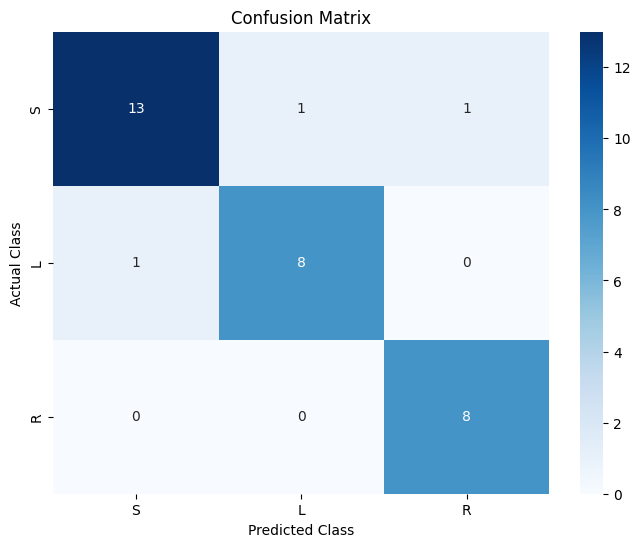

In [8]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
 
# 计算混淆矩阵
cm = confusion_matrix(real_labels, pred_labels)

# 可视化混淆矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['S', 'L', 'R'], yticklabels=['S', 'L', 'R'])
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.title('Confusion Matrix')
plt.savefig('co_drivin_cm.png')
plt.show()
